# Overview for Typescript

<br>  

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from neo4j import GraphDatabase

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [3]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename):
    records, summary, keys = driver.execute_query(get_cypher_query_from_file(filename))
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [5]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [6]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [7]:
# Main Colormap
main_color_map = 'nipy_spectral'

## Overview

### Table 1 - Size

In [8]:
overview_size = query_cypher_to_data_frame("../cypher/Overview/Overview_size_for_Typescript.cypher")
overview_size

,nodeCount,relationshipCount,projectCount,moduleCount,functionCount,objectCount,typeAliasCount,interfaceCount,classCount,methodCount
0,100437,299525,6,6,85,42,16,17,1,1


## Modules

### Table 2a - Largest 30 elements per module

This table shows the largest (number of elements) modules and their kind of elements (Interface, TypeAlias, Variable).
The whole table can be found in the CSV report `Number_of_elements_per_module_for_Typescript`.

In [9]:
elements_per_module = query_cypher_to_data_frame("../cypher/Overview/Number_of_elements_per_module_for_Typescript.cypher")
elements_per_module.drop(columns='fullQualifiedModuleName').head(30)

,moduleName,modulePath,numberOfModuleElements,languageElement,numberOfElements
0,react-router-dom,index.tsx,35,Interface,10
1,react-router-dom,index.tsx,35,Function,17
2,react-router-dom,index.tsx,35,Variable,5
3,react-router-dom,index.tsx,35,TypeAlias,3
4,react-router-native,index.tsx,12,TypeAlias,3
5,react-router-native,index.tsx,12,Function,7
6,react-router-native,index.tsx,12,Interface,2
7,react-router,index.ts,7,Function,2
8,react-router,index.ts,7,TypeAlias,5
9,server,server.tsx,6,Interface,2


### Table 2b - Largest 30 elements per module grouped

This table shows the largest (number of elements) modules each in one row, their kind of elements in columns and the count of them as values.

The source data for this aggregated table can be found in the CSV report `Number_of_elements_per_module_for_Typescript`.

In [10]:
# Pivot the DataFrame to 
# - group by the first column (moduleName) as new index
# - convert the values in the second column (typeLabel) 
# - into columns with the value of the third column (numberOfTypes).
elements_per_module_grouped = elements_per_module.pivot(index=['fullQualifiedModuleName', 'modulePath', 'moduleName'], columns='languageElement', values='numberOfElements')

# Fill missing values with zero
elements_per_module_grouped.fillna(0, inplace=True)

# Calculate the sum of values for each row
elements_per_module_grouped['Total'] = elements_per_module_grouped.sum(axis=1)

# Sort the DataFrame by the sum of values
elements_per_module_grouped.sort_values(by='Total', ascending=False, inplace=True)

# Remove the 'Total' column
elements_per_module_grouped.drop('Total', axis=1, inplace=True)

# Sort the order of the columns by their sum
column_sum = elements_per_module_grouped.sum()
elements_per_module_grouped = elements_per_module_grouped[column_sum.sort_values(ascending=False).index[:]]

# Convert all numeric columns to integers instead of decimal numbers with .0
elements_per_module_grouped = elements_per_module_grouped.astype(int)

# Reset the index to be able to select the module name representation (name, path, full)
# elements_per_module_grouped.reset_index(inplace=True)

# Convert to integer
elements_per_module_grouped.reset_index().drop(columns='fullQualifiedModuleName').head(30)

languageElement,modulePath,moduleName,Function,Interface,TypeAlias,Variable
0,index.tsx,react-router-dom,17,10,3,5
1,index.tsx,react-router-native,7,2,3,0
2,index.ts,react-router,2,0,5,0
3,server.tsx,server,4,2,0,0


### Table 2b Chart 1 - 30 largest modules and their elements stacked

<Figure size 640x480 with 0 Axes>

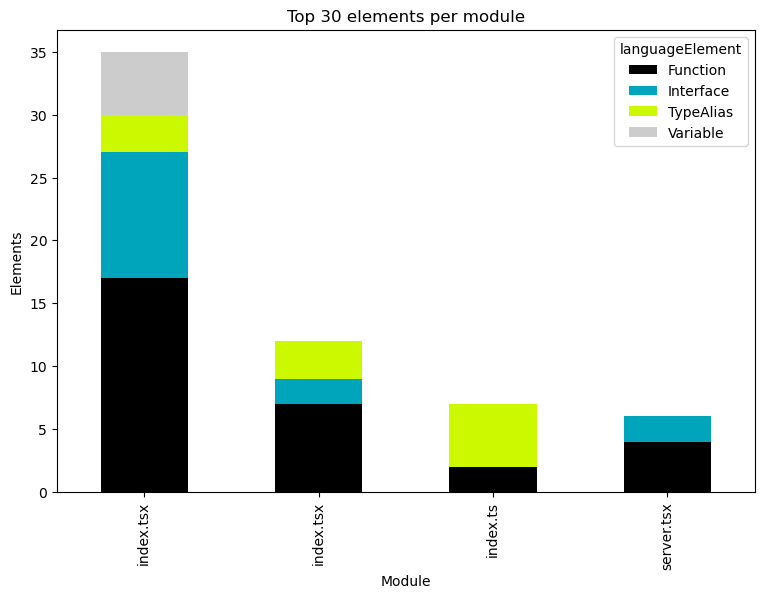

In [11]:
if elements_per_module_grouped.empty:
    print("No data to plot")
else:
    plot.figure();
    elements_per_module_grouped.reset_index().head(30).plot(
        kind='bar', 
        title='Top 30 elements per module',
        xlabel='Module',
        ylabel='Elements',
        x='modulePath',
        stacked=True, 
        cmap=main_color_map,
        figsize=(9, 6)
    )
    plot.show()

### Table 2c - 30 highest element count per module (grouped and normalized in %)

In [12]:
# Divide every value by the sum of the row to get horizontal normalized values.
# This makes it easier to compare the "language element" usage without taking the size of the module into account
elements_per_module_grouped_normalized = elements_per_module_grouped.div(elements_per_module_grouped.sum(axis=1), axis=0).multiply(100)
elements_per_module_grouped_normalized.reset_index().drop(columns='fullQualifiedModuleName').head(30)

languageElement,modulePath,moduleName,Function,Interface,TypeAlias,Variable
0,index.tsx,react-router-dom,48.571429,28.571429,8.571429,14.285714
1,index.tsx,react-router-native,58.333333,16.666667,25.000000,0.000000
2,index.ts,react-router,28.571429,0.000000,71.428571,0.000000
3,server.tsx,server,66.666667,33.333333,0.000000,0.000000


### Table 2c Chart 1 - Top 30 modules with the highest relative amount of type aliases in %

<Figure size 640x480 with 0 Axes>

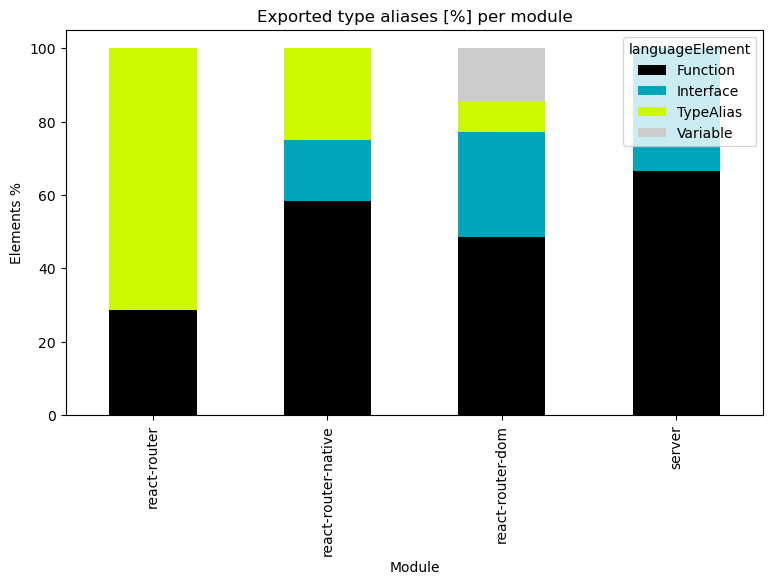

In [13]:
if elements_per_module_grouped_normalized.empty:
    print("No data to plot")
else:
    elements_per_module_sorted_by_type_alias=elements_per_module_grouped_normalized.sort_values(by='TypeAlias', ascending=False)
    
    plot.figure();
    elements_per_module_sorted_by_type_alias.reset_index().head(30).plot(
        x='moduleName',
        kind='bar', 
        stacked=True, 
        cmap=main_color_map, 
        figsize=(9, 5)
    )
    plot.xlabel('Module')
    plot.ylabel('Elements %')
    plot.title('Exported type aliases [%] per module')
    plot.show()

### Table 2c Chart 2 - Top 30 module with the highest relative amount of interfaces in %

<Figure size 640x480 with 0 Axes>

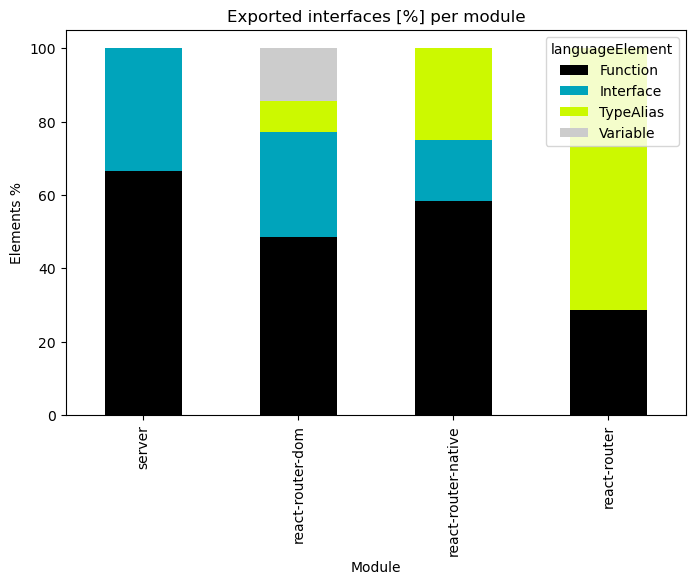

In [14]:
if elements_per_module_grouped_normalized.empty:
    print("No data to plot")
else:
    elements_per_module_sorted_by_interfaces=elements_per_module_grouped_normalized.sort_values(by='Interface', ascending=False)
    
    plot.figure();
    elements_per_module_sorted_by_interfaces.reset_index().head(30).plot(
        x='moduleName',
        kind='bar', 
        stacked=True, 
        cmap=main_color_map, 
        figsize=(8, 5)
    )
    plot.xlabel('Module')
    plot.ylabel('Elements %')
    plot.title('Exported interfaces [%] per module')
    plot.show()

### Table 2c Chart 3 - Top 30 modules with the highest relative amount of variables in %

<Figure size 640x480 with 0 Axes>

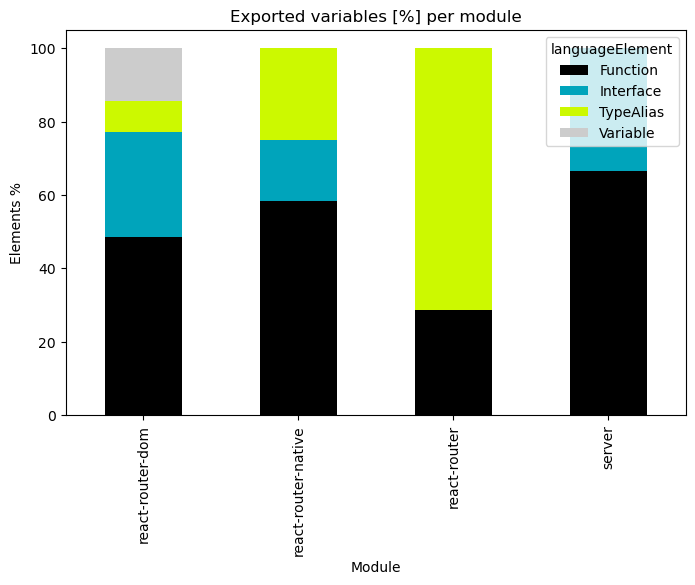

In [15]:
if elements_per_module_grouped_normalized.empty:
    print("No data to plot")
else:
    elements_per_module_sorted_by_variables=elements_per_module_grouped_normalized.sort_values(by='Variable', ascending=False)
    plot.figure();
    elements_per_module_sorted_by_variables.reset_index().head(30).plot(
        x='moduleName',
        kind='bar', 
        stacked=True, 
        cmap=main_color_map, 
        figsize=(8, 5)
    )
    plot.xlabel('Module')
    plot.ylabel('Elements %')
    plot.title('Exported variables [%] per module')
    plot.show()

### Table 2c Chart 4 - Top 30 modules with the highest relative amount of functions in %

<Figure size 640x480 with 0 Axes>

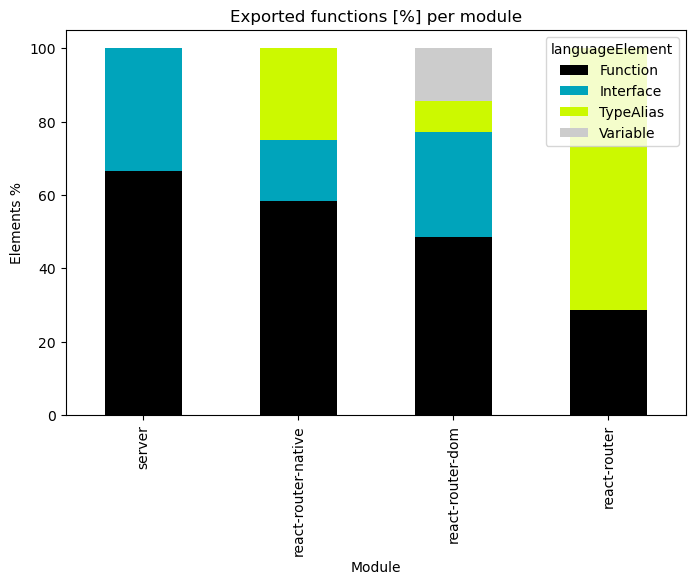

In [16]:
if elements_per_module_grouped_normalized.empty:
    print("No data to plot")
else:
    elements_per_module_sorted_by_functions=elements_per_module_grouped_normalized.sort_values(by='Function', ascending=False)
    plot.figure();
    elements_per_module_sorted_by_functions.reset_index().head(30).plot(
        x='moduleName',
        kind='bar', 
        stacked=True, 
        cmap=main_color_map, 
        figsize=(8, 5)
    )
    plot.xlabel('Module')
    plot.ylabel('Elements %')
    plot.title('Exported functions [%] per module')
    plot.show()